hello kagglers, this is my first kernel on kaggle. I would like to show my Monkey Classifier using ResNet-50. I built it using Keras pre trained model, with difference on last few layer. Feel free to write any advice for on the comment section, thanks!

**1. Importing required Library**

In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGE = True

Using TensorFlow backend.


**2. Define some constant needed throughout the script**

In [2]:
N_CLASSES = 10
EPOCHS = 15
PATIENCE = 5
TRAIN_PATH= '../input/training/training/'
VALID_PATH = '../input/validation/validation/'
MODEL_CHECK_WEIGHT_NAME = 'resnet_monki_v1_chk.h5'

**3. Define model to be used**
we freeze the pre trained resnet model weight, and add few layer on top of it to utilize our custom dataset


In [3]:
K.set_learning_phase(0)
model = ResNet50(input_shape=(224,224,3),include_top=False, weights='imagenet', pooling='avg')
K.set_learning_phase(1)
x = model.output
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(N_CLASSES, activation='softmax', name='custom_output')(x)
custom_resnet = Model(inputs=model.input, outputs = output)

for layer in model.layers:
    layer.trainable = False

custom_resnet.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
custom_resnet.summary()

Instructions for updating:
Colocations handled automatically by placer.
94658560/94653016 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
_______________________________________________________

**4. Load dataset to be used**

In [4]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
traingen = datagen.flow_from_directory(TRAIN_PATH, target_size=(224,224), batch_size=32, class_mode='categorical')
validgen = datagen.flow_from_directory(VALID_PATH, target_size=(224,224), batch_size=32, class_mode='categorical', shuffle=False)

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


**5. Train Model**
we use ModelCheckpoint to save the best model based on validation accuracy


In [5]:
es_callback = EarlyStopping(monitor='val_acc', patience=PATIENCE, mode='max')
mc_callback = ModelCheckpoint(filepath=MODEL_CHECK_WEIGHT_NAME, monitor='val_acc', save_best_only=True, mode='max')
train_history = custom_resnet.fit_generator(traingen, steps_per_epoch=len(traingen), epochs= EPOCHS, validation_data=traingen, validation_steps=len(validgen), verbose=2, callbacks=[es_callback, mc_callback])


Instructions for updating:
Use tf.cast instead.
Epoch 1/15
 - 35s - loss: 1.1960 - acc: 0.6280 - val_loss: 0.4027 - val_acc: 0.8611
Epoch 2/15
 - 22s - loss: 0.2853 - acc: 0.9084 - val_loss: 0.2151 - val_acc: 0.9097
Epoch 3/15
 - 29s - loss: 0.1295 - acc: 0.9589 - val_loss: 0.1452 - val_acc: 0.9583
Epoch 4/15
 - 32s - loss: 0.0663 - acc: 0.9768 - val_loss: 0.0985 - val_acc: 0.9688
Epoch 5/15
 - 30s - loss: 0.0683 - acc: 0.9741 - val_loss: 0.0584 - val_acc: 0.9826
Epoch 6/15
 - 32s - loss: 0.1055 - acc: 0.9710 - val_loss: 0.0806 - val_acc: 0.9722
Epoch 7/15
 - 29s - loss: 0.0541 - acc: 0.9830 - val_loss: 0.0717 - val_acc: 0.9811
Epoch 8/15
 - 32s - loss: 0.0553 - acc: 0.9866 - val_loss: 0.0475 - val_acc: 0.9887
Epoch 9/15
 - 31s - loss: 0.0448 - acc: 0.9848 - val_loss: 0.0826 - val_acc: 0.9757
Epoch 10/15
 - 29s - loss: 0.0451 - acc: 0.9848 - val_loss: 0.0510 - val_acc: 0.9826
Epoch 11/15
 - 32s - loss: 0.0848 - acc: 0.9777 - val_loss: 0.1549 - val_acc: 0.9757
Epoch 12/15
 - 33s - loss:

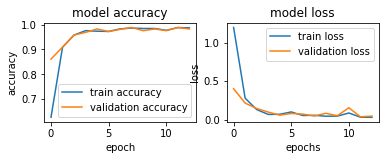

In [6]:
plt.figure(1)
plt.subplot(221)
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy','validation accuracy'])

plt.subplot(222)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'])

plt.show()

**7. Load Last Checkpoint Weight**

In [7]:
custom_resnet.load_weights(MODEL_CHECK_WEIGHT_NAME)

**7. Print validation confusion matrix, classification report, and accuracy**

In [8]:
predict = custom_resnet.predict_generator(validgen, steps=len(validgen), verbose=1)
test_labels = validgen.classes
confusion_matrix(test_labels, predict.argmax(axis=1))


9/9 [==============================] - 9s 945ms/step


array([[26,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 26,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0, 29,  0,  0,  1,  0,  0,  0],
       [ 1,  0,  0,  0, 25,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 27,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 25,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 28,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 27,  0],
       [ 1,  0,  0,  0,  1,  0,  0,  0,  0, 24]])

In [9]:
cr_labels = list(validgen.class_indices.keys())
classification_report(test_labels, predict.argmax(axis=1), target_names=cr_labels)

'              precision    recall  f1-score   support\n\n          n0       0.90      1.00      0.95        26\n          n1       1.00      1.00      1.00        28\n          n2       1.00      0.96      0.98        27\n          n3       1.00      0.97      0.98        30\n          n4       0.96      0.96      0.96        26\n          n5       0.96      0.96      0.96        28\n          n6       0.96      0.96      0.96        26\n          n7       1.00      1.00      1.00        28\n          n8       0.96      1.00      0.98        27\n          n9       1.00      0.92      0.96        26\n\n   micro avg       0.97      0.97      0.97       272\n   macro avg       0.97      0.97      0.97       272\nweighted avg       0.98      0.97      0.97       272\n'

In [10]:
accuracy_score(test_labels,predict.argmax(axis=1))

0.9742647058823529